In [1]:
from PIL import Image

In [53]:
def generate_map(image_path, palette_path):
    image = Image.open(image_path)
    pixels = image.load()
    width, height = image.size

    palette = Image.open(palette_path)
    palette_pixels = palette.load()
    palette_width, palette_height = palette.size

    if palette_height != 3:
        raise ValueError("Palette image must be 1 pixel tall")

    palette_colors = []
    for x in range(palette_width):
        palette_colors.append(palette_pixels[x, 0])
    
    palette_color_numbers = {}
    for x in range(palette_width):
        palette_color_numbers[palette_pixels[x, 2]] = x

    palette_map = {}
    for x in range(palette_width):
        palette_map[palette_pixels[x, 0]] = palette_color_numbers[palette_pixels[x, 1]]

    high_level_map = []
    for y in range(height):
        row = []
        for x in range(width):
            row.append(palette_map[pixels[x, y]])
        high_level_map.append(row)

    room_neighbors = []

    OFFSETS = [(1, 0), (0, 1), (-1, 0), (0, -1)]
    for room_y in range(height):
        neighbors_row = []
        for room_x in range(width):
            if high_level_map[room_y][room_x] == 0:
                neighbors_row.append(0)
                continue
            neighbors = 0
            for i, (dx, dy) in enumerate(OFFSETS):
                if room_x + dx < 0 or room_x + dx >= width or room_y + dy < 0 or room_y + dy >= height:
                    continue
                if not (high_level_map[room_y + dy][room_x + dx] == 0):
                    neighbors = neighbors | (1 << i)
            neighbors_row.append(neighbors)
        room_neighbors.append(neighbors_row)

    ROOM_SIZE = 16
    full_image = Image.new("RGBA", (width * ROOM_SIZE, height * ROOM_SIZE))

    TILE = (0, 0, 0, 255)
    EMPTY = (0, 0, 0, 0)
    room_full = Image.new("RGBA", (ROOM_SIZE, ROOM_SIZE))
    room_stencil = Image.new("RGBA", (ROOM_SIZE, ROOM_SIZE))
    for y in range(ROOM_SIZE):
        for x in range(ROOM_SIZE):
            room_full.putpixel((x, y), TILE)
            room_stencil.putpixel((x, y), TILE)
    
    for y in range(ROOM_SIZE - 2):
        for x in range(ROOM_SIZE - 2):
            room_stencil.putpixel((x + 1, y + 1), EMPTY)

    DOOR_OFFSETS = [
        [
            (ROOM_SIZE - 1, 6),
            (ROOM_SIZE - 1, 7),
            (ROOM_SIZE - 1, 8),
            (ROOM_SIZE - 1, 9),
        ],
        [
            (6, ROOM_SIZE - 1),
            (7, ROOM_SIZE - 1),
            (8, ROOM_SIZE - 1),
            (9, ROOM_SIZE - 1),
        ],
        [
            (0, 6),
            (0, 7),
            (0, 8),
            (0, 9),
        ],
        [
            (6, 0),
            (7, 0),
            (8, 0),
            (9, 0),
        ],
    ]
    for room_y in range(height):
        for room_x in range(width):
            if high_level_map[room_y][room_x] == 0:
                full_image.paste(room_full, (room_x * ROOM_SIZE, room_y * ROOM_SIZE))
            else:
                full_image.paste(room_stencil, (room_x * ROOM_SIZE, room_y * ROOM_SIZE))
                for i, (dx, dy) in enumerate(OFFSETS):
                    if room_neighbors[room_y][room_x] & (1 << i):
                        for (offset_x, offset_y) in DOOR_OFFSETS[i]:
                            full_image.putpixel((room_x * ROOM_SIZE + offset_x, room_y * ROOM_SIZE + offset_y), EMPTY)
    
    return full_image

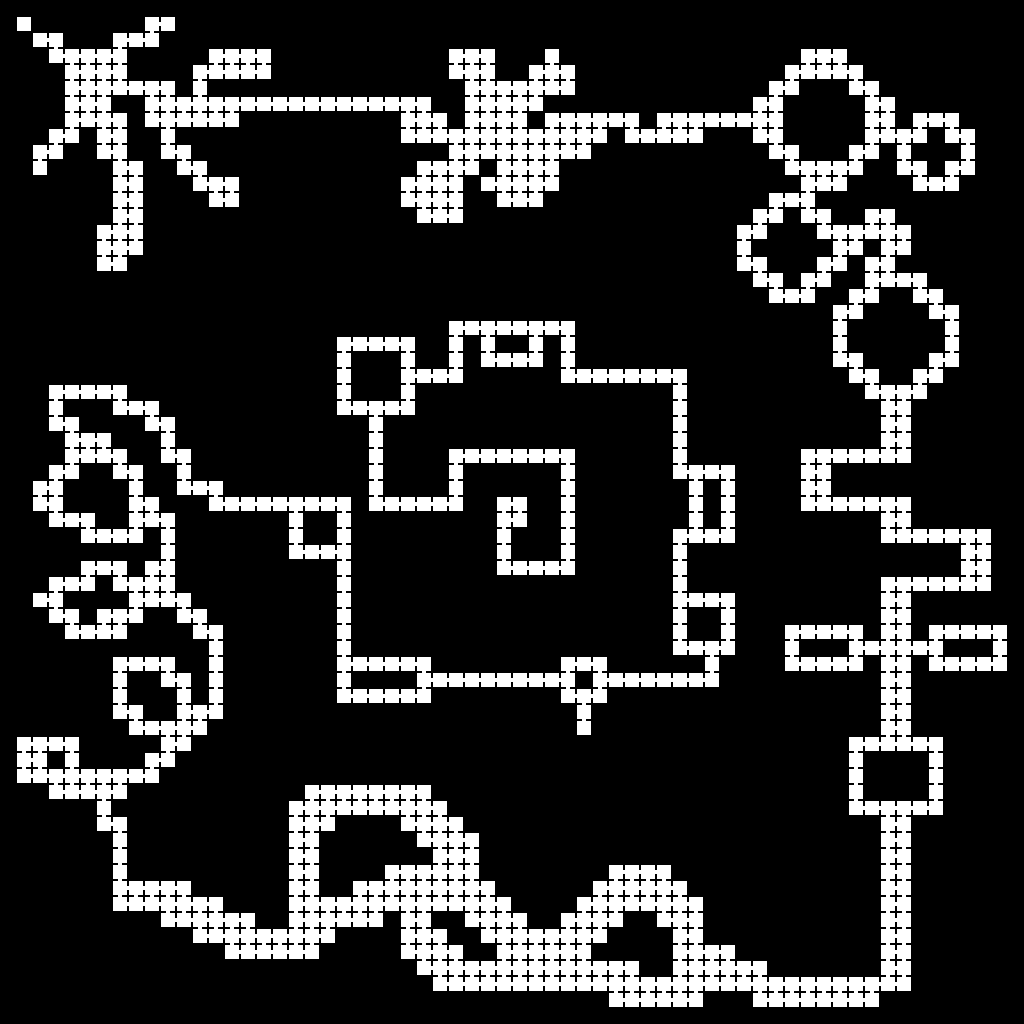

In [54]:
generate_map("../content/textures/high_level_map.png", "../content/textures/high_level_map_palette.png")